## Setup environment

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.3 MB/s eta 0:00:00


## Setup imports

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import monai
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    SqueezeDimd,
    Resized,
    ResizeWithPadOrCropd,
    EnsureTyped
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.2.dev2310
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7521d7701bb73057952650d982e38467d219ed5b
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.11.2
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-re

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC"

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC


## Setup transforms for training and validation

(Auch interessant, copy items, diese haben dann verschiedene keys (comment in https://github.com/Project-MONAI/MONAI/discussions/3707): \\
```LoadImaged(keys="img"), 
EnsureChannelFirstd(keys="img"), 
CopyItemsd(keys="img", times=3),
SpatialCropd(keys="img", roi_start=..., roi_end=...),
SpatialCropd(keys="img_0", roi_start=..., roi_end=...),
SpatialCropd(keys="img_1", roi_start=..., roi_end=...),
SpatialCropd(keys="img_2", roi_start=..., roi_end=...),)```

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 16),
        #     pos=1,
        #     neg=1,
        #     # num_samples=4,
        #     num_samples=1,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        EnsureTyped(keys=["image", "label"]), # newly added
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
# data_dir = "/dataset/"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
data_dir = (directory + "/")
print(f"In meinem Colab Folder sind folgende Inhalte: {os.listdir(data_dir)}")
split_json = "dataset_ACDC_MONAI.json"

datasets = data_dir + split_json

datalist = load_decathlon_datalist(datasets, True, "training")  # Guckt sich hier dann an, was im json genau dieses "training" (oder "validation" oder "test") sein soll

print(f"Example what contents are in the 'datalist' dicitionary for training: {datalist[17]}")

val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    # cache_num=24,
    # cache_rate=1.0,
    num_workers=4,
)

#print(f"Example what contents are in the 'train_ds' dicitionary for training: {train_ds[17]}")

train_loader0 = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


check_data = monai.utils.misc.first(train_loader0)
print("first volume's shape for training: ", check_data["image"].shape, check_data["label"].shape)
print("Erinnerung: Ich mache hier bei der transform <RandCropByPosNegLabeld> vier samples. Daher ist bei batch_size = 1 die Dimension <0> = 4 und z. B. bei batch_size=8 ist diese Dimension <0> 4*8=32")
check_data = monai.utils.misc.first(val_loader)
print("first volume's shape for validation: ", check_data["image"].shape, check_data["label"].shape)

In meinem Colab Folder sind folgende Inhalte: ['imagesTs', 'imagesTr', 'labelsTr', 'dataset.json', 'best_metric_model.pth', 'dataset_ACDC_MONAI.json', 'imagesVal', 'labelsVal', 'labelsTs', 'best_metric_model_ACDC_2D_10074iterations_88min_8RandomCropSamples.pth', 'LossAndDiceScoreOverIterations_unetr_ACDC_2D.pdf', '0Result_unetr_ACDC_2D.pdf', '1Result_unetr_ACDC_2D.pdf', '2Result_unetr_ACDC_2D.pdf', '3Result_unetr_ACDC_2D.pdf', '4Result_unetr_ACDC_2D.pdf', 'best_metric_model_ACDC_2D_BADresult_42min_PadOrCropd_4Samples.pth', '0Result_Test_unetr_ACDC_2D.pdf', '1Result_Test_unetr_ACDC_2D.pdf', '2Result_Test_unetr_ACDC_2D.pdf', '3Result_Test_unetr_ACDC_2D.pdf', '4Result_Test_unetr_ACDC_2D.pdf']
Example what contents are in the 'datalist' dicitionary for training: {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTr/patient017_frame01_0000.nii.gz', 'label': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/labelsTr/patient017_frame01.nii.gz'}


Loading dataset: 100%|██████████| 35/35 [00:23<00:00,  1.52it/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid p

first volume's shape for training:  torch.Size([1, 1, 214, 253, 46]) torch.Size([1, 1, 214, 253, 46])
Erinnerung: Ich mache hier bei der transform <RandCropByPosNegLabeld> vier samples. Daher ist bei batch_size = 1 die Dimension <0> = 4 und z. B. bei batch_size=8 ist diese Dimension <0> 4*8=32
first volume's shape for validation:  torch.Size([1, 1, 208, 247, 36]) torch.Size([1, 1, 208, 247, 36])


In [ ]:
#print(train_ds[1])

WidthLength = 16*8

patch_func = monai.data.PatchIterd(
    keys=["image", "label"], patch_size=(None, None, 1), start_pos=(0, 0, 0)  # dynamic first two dimensions
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        # Resized(keys=["image", "label"], spatial_size=[96, 96]),
        # to use crop/pad instead of resize:
        # ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=[96, 96], mode="replicate", num_samples = 4,)
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(WidthLength, WidthLength),
            pos=1,
            neg=1,
            # num_samples=4,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
patch_ds = monai.data.GridPatchDataset(
    data=train_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False
)
shuffle_ds = monai.data.ShuffleBuffer(patch_ds, buffer_size=30)#, seed=0)
train_loader = DataLoader(
    shuffle_ds,
    # patch_ds,
    batch_size=5,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

print(train_loader)

check_data = monai.utils.misc.first(train_loader)
print("first patch's shape: ", check_data["image"].shape, check_data["label"].shape)

/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


first patch's shape:  torch.Size([20, 1, 128, 128]) torch.Size([20, 1, 128, 128])


## Check data shape and visualize

image shape: torch.Size([1, 208, 247, 36]), label shape: torch.Size([1, 208, 247, 36])


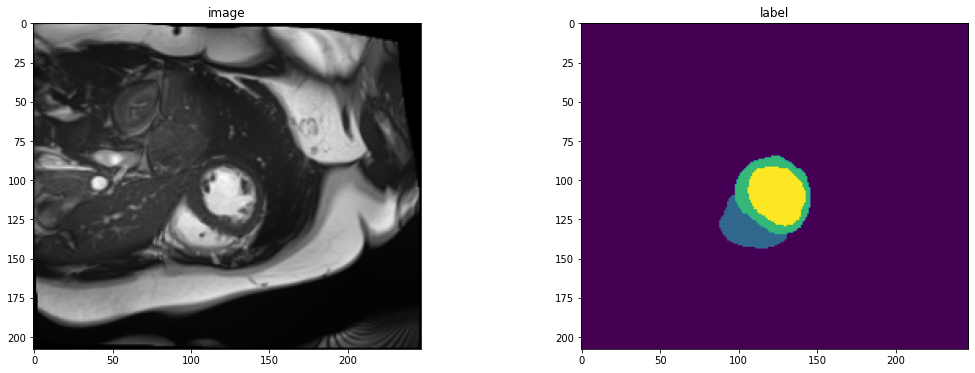

In [ ]:
slice_map = {
    # "img0035.nii.gz": 170,
    "patient036_frame01.nii.gz": 13,
    "patient037_frame01.nii.gz": 18,
    "patient038_frame01.nii.gz": 22,
    "patient039_frame01.nii.gz": 9,
    "patient040_frame01.nii.gz": 15,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create 2D Model, Loss for multi-class problem and Optimizer


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=4,   # was 14 for btcv
    img_size=WidthLength,  # was (96, 96, 96)
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    spatial_dims=2,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process 
(3D Training: 10000 iterations with 35 training and 5 validation images takes -> about 1h 45min)

(2D Training: 10000 iteration with 35 training (3D) and 8 num_samples des random crops -> about 2 * 45 min)

(Iterations are the number of batches needed to complete one epoch. Example: 2000 train images with a batch size of 500 takes 4 iterations to complete 1 epoch)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            
            slice_inferer = monai.inferers.SliceInferer(
                                        roi_size=(WidthLength, WidthLength),
                                        sw_batch_size=3,
                                        spatial_dim=2,  # Spatial dim to slice along is defined here -> 0 axial, 1 coronal, 2 sagittal  ## https://docs.monai.io/en/stable/inferers.html
                                        device=torch.device("cuda"),
                                        padding_mode="replicate",
                                        )
            val_outputs = slice_inferer(val_inputs, model).to(device)
            val_labels_list = decollate_batch(val_labels)                                           # Mit allen 2D Slices des 3D Trainingsbildes kann ich wieder alle 2D Slices des 3D ground truth labels nehmen

            ## Alternativ nur 1 2D slice verwenden:
            # val_outputs = sliding_window_inference(val_inputs[:,:,:,:,0], (96, 96), 4, model)     # Das 2D Model benötigt auch 2D Validation Data, 3D validation Data geht nicht! Hier entsprechend nur 1 2D Slice des 3D Bildes
            # val_labels_list = decollate_batch(val_labels[:,:,:,:,0])                              # Wenn ich nur einen 2D Slice des Trainingsbildes habe, dann darf ich auch nur den 2D Slice des dazugehörigen labels nehmen

            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_ACDC_2D.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

epoch = 35 # num_training_files
# 35 examples with a batch size of 5 means that it will take 7 iterations to complete 1 epoch. -> 10000 iterations are 1400 epochs?? // 10E3 / (35/5) = 10000 / 7
# But I have 35 * slice_num * num_samples_from_random_crop examples? So with a slice_num of about 40 -> 10000 iterations are about 10000_{iterations} * 5_{batch_size} / (35_{3Dexamples} * 40_{slice_num} * 8_{crop_samples})
# = 10E3 * 5 / (35*40*8) => 4.5 Epochen?
# So I have about 35 * 40 2D slices which I'm taking 8 randomly cropped samples from. -> 11200 examples. Those are put into batches of size 5 -> 2240 batches -> I train over 4 epochs.
max_iterations = 10000 # ~285 * epoch
eval_num = 500
post_label = AsDiscrete(to_onehot=4) #14
post_pred = AsDiscrete(argmax=True, to_onehot=4) #14
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_3D.pth")))

Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (14 / 10000 Steps) (loss=2.21646): : 15it [00:16,  2.88it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 81600, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (15 / 10000 Steps) (loss=2.20717): : 16it [00:16,  3.01it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting 

Model Was Saved ! Current Best Avg. Dice: 0.3292398452758789 Current Avg. Dice: 0.3292398452758789


Training (587 / 10000 Steps) (loss=1.20605): : 123it [01:00,  2.55it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (619 / 10000 Steps) (loss=1.12718): : 155it [01:10,  2.19it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (634 / 10000 Steps) (loss=1.23750): : 15it [00:07,  3.08it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0,

Model Was Saved ! Current Best Avg. Dice: 0.3314865231513977 Current Avg. Dice: 0.3314865231513977


Training (1052 / 10000 Steps) (loss=1.00824): : 123it [00:58,  3.05it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (1084 / 10000 Steps) (loss=0.91461): : 155it [01:09,  2.24it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (1099 / 10000 Steps) (loss=1.05573): : 15it [00:06,  2.69it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Saved ! Current Best Avg. Dice: 0.37399744987487793 Current Avg. Dice: 0.37399744987487793


Training (1517 / 10000 Steps) (loss=0.85139): : 123it [00:56,  2.53it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (1549 / 10000 Steps) (loss=0.75216): : 155it [01:07,  2.28it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (1564 / 10000 Steps) (loss=0.92787): : 15it [00:07,  3.13it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Saved ! Current Best Avg. Dice: 0.4887412190437317 Current Avg. Dice: 0.4887412190437317


Training (2014 / 10000 Steps) (loss=0.59751): : 155it [01:07,  2.31it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (2029 / 10000 Steps) (loss=0.82293): : 15it [00:06,  2.56it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 81600, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (2031 / 10000 Steps) (loss=0.84581): : 17it [00:07,  2.34it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 

Model Was Saved ! Current Best Avg. Dice: 0.5301609039306641 Current Avg. Dice: 0.5301609039306641


Training (2602 / 10000 Steps) (loss=0.66211): : 123it [00:57,  2.54it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (2634 / 10000 Steps) (loss=0.49544): : 155it [01:08,  2.26it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (2649 / 10000 Steps) (loss=0.74479): : 15it [00:07,  2.45it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.5501362681388855


Training (3067 / 10000 Steps) (loss=0.60595): : 123it [00:57,  3.07it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (3099 / 10000 Steps) (loss=0.41698): : 155it [01:07,  2.29it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (3114 / 10000 Steps) (loss=0.71094): : 15it [00:06,  3.09it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.457236111164093


Training (3532 / 10000 Steps) (loss=0.57404): : 123it [00:56,  3.05it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (3564 / 10000 Steps) (loss=0.35885): : 155it [01:07,  2.28it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (3579 / 10000 Steps) (loss=0.65989): : 15it [00:06,  3.10it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.5253806114196777


Training (4029 / 10000 Steps) (loss=0.32663): : 155it [01:06,  2.35it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (4044 / 10000 Steps) (loss=0.59794): : 15it [00:07,  2.25it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 81600, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (4045 / 10000 Steps) (loss=0.38284): : 16it [00:07,  2.38it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 

Model Was Not Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.5376979112625122


Training (4509 / 10000 Steps) (loss=0.56394): : 15it [00:17,  1.84it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 81600, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (4510 / 10000 Steps) (loss=0.40221): : 16it [00:18,  2.13it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (4617 / 10000 Steps) (loss=0.53087): : 123it [00:55,  3.09it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (4649 / 10000 Steps) (loss=0.29379): : 155it [01:06,  2.34it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/di

Model Was Not Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.5437800288200378


Training (5082 / 10000 Steps) (loss=0.46660): : 123it [00:55,  2.52it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (5114 / 10000 Steps) (loss=0.27345): : 155it [01:05,  2.36it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (5129 / 10000 Steps) (loss=0.54997): : 15it [00:07,  2.63it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.42463380098342896


Training (5547 / 10000 Steps) (loss=0.45446): : 123it [00:54,  2.29it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (5579 / 10000 Steps) (loss=0.27810): : 155it [01:04,  2.38it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (5594 / 10000 Steps) (loss=0.50181): : 15it [00:08,  2.92it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.5006165504455566


Training (6012 / 10000 Steps) (loss=0.41293): : 123it [00:55,  2.63it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (6044 / 10000 Steps) (loss=0.26675): : 155it [01:05,  2.37it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (6059 / 10000 Steps) (loss=0.49395): : 15it [00:07,  3.10it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5501362681388855 Current Avg. Dice: 0.5059561729431152


Training (6509 / 10000 Steps) (loss=0.25055): : 155it [01:07,  2.30it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (6524 / 10000 Steps) (loss=0.48087): : 15it [00:06,  3.12it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 81600, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (6525 / 10000 Steps) (loss=0.26868): : 16it [00:06,  3.17it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 

Model Was Saved ! Current Best Avg. Dice: 0.555831253528595 Current Avg. Dice: 0.555831253528595


Training (7097 / 10000 Steps) (loss=0.38822): : 123it [00:58,  3.11it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (7129 / 10000 Steps) (loss=0.24723): : 155it [01:09,  2.24it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (7144 / 10000 Steps) (loss=0.47171): : 15it [00:06,  3.11it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Saved ! Current Best Avg. Dice: 0.5593875646591187 Current Avg. Dice: 0.5593875646591187


Training (7562 / 10000 Steps) (loss=0.38547): : 123it [00:57,  3.18it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (7594 / 10000 Steps) (loss=0.22338): : 155it [01:08,  2.27it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (7609 / 10000 Steps) (loss=0.52320): : 15it [00:06,  2.37it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5593875646591187 Current Avg. Dice: 0.46086573600769043


Training (8027 / 10000 Steps) (loss=0.36402): : 123it [00:54,  2.33it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (8059 / 10000 Steps) (loss=0.21551): : 155it [01:04,  2.39it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (8074 / 10000 Steps) (loss=0.47896): : 15it [00:07,  2.82it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5593875646591187 Current Avg. Dice: 0.4808712899684906


Training (8524 / 10000 Steps) (loss=0.20644): : 155it [01:04,  2.42it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (8539 / 10000 Steps) (loss=0.42359): : 15it [00:07,  3.13it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 81600, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (8540 / 10000 Steps) (loss=0.25134): : 16it [00:07,  3.17it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 

Model Was Not Saved ! Current Best Avg. Dice: 0.5593875646591187 Current Avg. Dice: 0.49571093916893005


Training (9004 / 10000 Steps) (loss=0.43427): : 15it [00:17,  1.06s/it]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 81600, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (9005 / 10000 Steps) (loss=0.22433): : 16it [00:18,  1.20it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (9112 / 10000 Steps) (loss=0.34399): : 123it [00:56,  3.08it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (9144 / 10000 Steps) (loss=0.20767): : 155it [01:06,  2.34it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/di

Model Was Not Saved ! Current Best Avg. Dice: 0.5593875646591187 Current Avg. Dice: 0.5475465059280396


Training (9577 / 10000 Steps) (loss=0.33502): : 123it [00:54,  3.15it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (9609 / 10000 Steps) (loss=0.19090): : 155it [01:04,  2.39it/s]
Training (X / X Steps) (loss=X.X): 0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 51376, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 60075, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (9624 / 10000 Steps) (loss=0.36668): : 15it [00:07,  2.75it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds

Model Was Not Saved ! Current Best Avg. Dice: 0.5593875646591187 Current Avg. Dice: 0.4557529389858246


Training (10042 / 10000 Steps) (loss=0.31750): : 123it [00:54,  3.18it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/utils.py:515: UserWarning: Num foregrounds 0, Num backgrounds 62211, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(
Training (10074 / 10000 Steps) (loss=0.19425): : 155it [01:05,  2.36it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D.pth")))

<All keys matched successfully>

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.5594 at iteration: 7500


### Plot the loss and metric - for every 500 iterations due to eval_num = 500

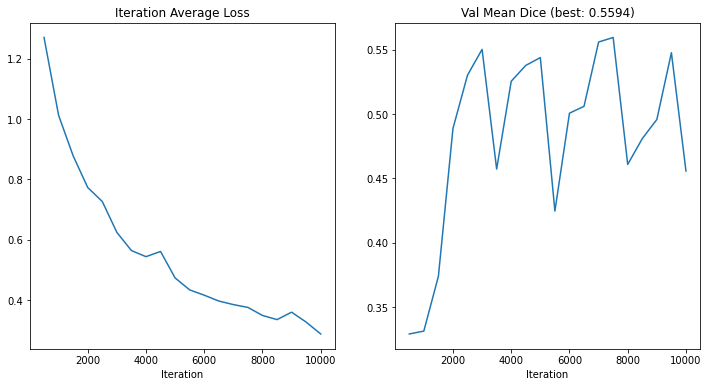

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice (best: %.4f)" %(dice_val_best))
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.savefig(os.path.join(root_dir, "LossAndDiceScoreOverIterations_unetr_ACDC_2D.pdf"))
plt.show()

### Check best model output with the input image and label

Before the third to last line of code, "val_outputs" is currently a MetaTensor of shape (1, 4, W, L). What does torch.argmax(val_outputs, dim=1) do?

→ torch.argmax(val_outputs, dim=1) is a PyTorch function that returns the indices of the maximum values along the specified dimension, which in this case is the second dimension (index 1), i.e. the 4 channels/labels.

→ Since the val_output tensor has shape (1, 4, 206, 253), this function will return a new tensor of shape (1, 206, 253), where each element in the tensor corresponds to the index of the maximum value along the second dimension. In other words, it returns the predicted label index (out of the four possible labels) for each pixel in the 2D slice.

Taking testABC = 5


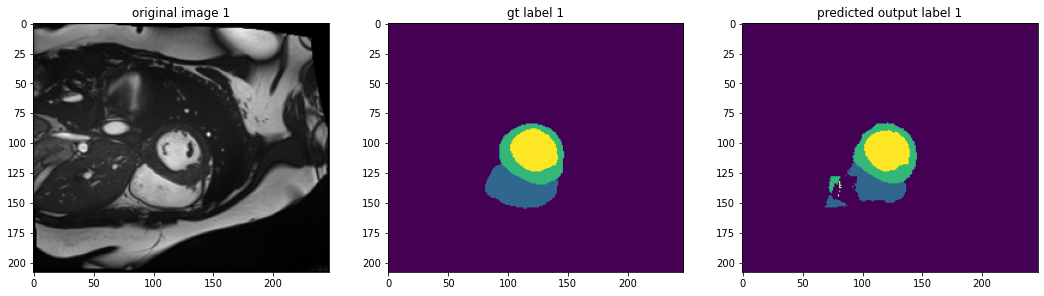

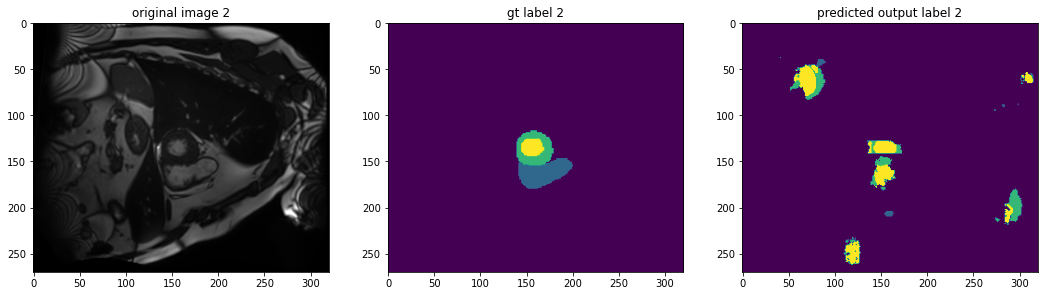

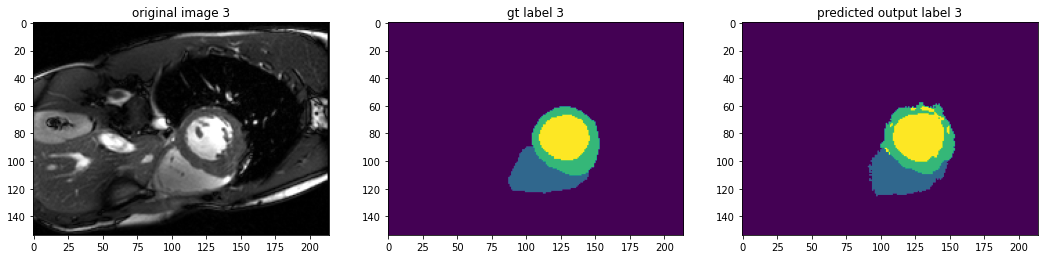

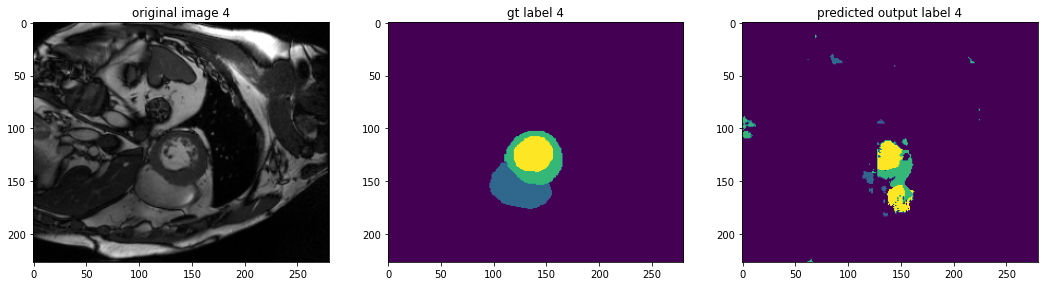

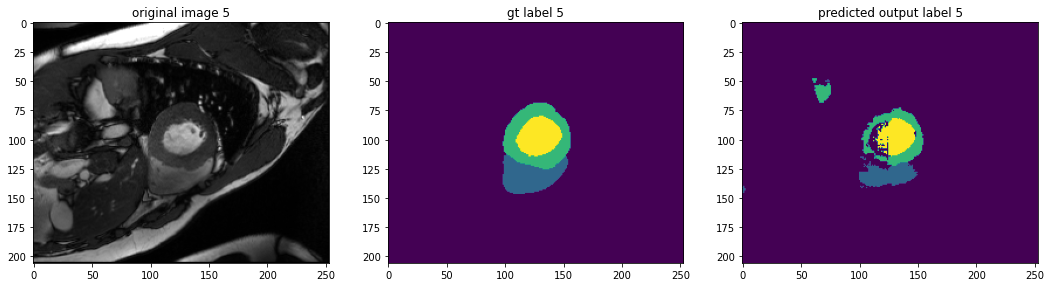

In [ ]:
import random
# testABC = slice_map[img_name]
testABC = random.randint(0,10)
print(f"Taking testABC = {testABC}")
for case_num in [0,1,2,3,4]:
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D.pth"))) # "best_metric_model_ACDC_2D_10074iterations_88min_8RandomCropSamples.pth"
  model.eval()
  with torch.no_grad():
      img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
      img = val_ds[case_num]["image"]
      label = val_ds[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      # val_outputs = sliding_window_inference(val_inputs[:,:,:,:,0], (WidthLength, WidthLength), 4, model, overlap=0.8)
      slice_inferer = monai.inferers.SliceInferer(
                                        roi_size=(WidthLength, WidthLength),
                                        sw_batch_size=3,
                                        spatial_dim=2,  # Spatial dim to slice along is defined here -> 0 axial, 1 coronal, 2 sagittal  ## https://docs.monai.io/en/stable/inferers.html
                                        device=torch.device("cuda"),
                                        padding_mode="replicate",
                                        )
      val_outputs = slice_inferer(val_inputs, model).to(device)
      plt.figure("check", (18, 6))
      plt.subplot(1, 3, 1)
      plt.title("original image %i" %(case_num+1))
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, testABC], cmap="gray")
      plt.subplot(1, 3, 2)
      plt.title("gt label %i" %(case_num+1))
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, testABC])
      plt.subplot(1, 3, 3)
      plt.title("predicted output label %i" %(case_num+1))
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, testABC])
      # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :])
      plt.savefig(os.path.join(root_dir, str(case_num) + "Result_unetr_ACDC_2D.pdf"))
      plt.show()


Test Images laden

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"],
                pixdim=(1.5, 1.5, 2.0),
                ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_files = load_decathlon_datalist(datasets, False, "test")

print(test_files)

#print(f"Example what contents are in the 'train_ds' dicitionary for training: {train_ds[17]}")

test_ds = CacheDataset(data=test_files, transform=test_transforms, num_workers=4)    # ohne eine transform mit loadImaged bleibt der Eintrag eine Liste mit dem path/to/file/patient.nii.gz
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

check_test_data = monai.utils.misc.first(test_loader)
print(check_test_data.keys())

print("first volume's shape for test/inference: ", check_test_data["image"].shape)
# print("first volume's shape for test/inference: ", check_test_data["image"].shape, check_test_data["label"].shape)

print(f"Im test_loader befinden sich nun {len(test_loader)} Elemente")

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


[{'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient041_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient043_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient042_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient044_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient048_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient047_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient046_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Task901_ACDC/imagesTs/patient049_frame01_0000.nii.gz'}, {'image': '/content/drive/MyDrive/Colab Notebooks/MONAI/data/Ta

Loading dataset: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dict_keys(['image', 'image_meta_dict', 'foreground_start_coord', 'foreground_end_coord'])
first volume's shape for test/inference:  torch.Size([1, 1, 183, 266, 26])
Im test_loader befinden sich nun 10 Elemente


Test Images überprüfen

Taking testABC = 3


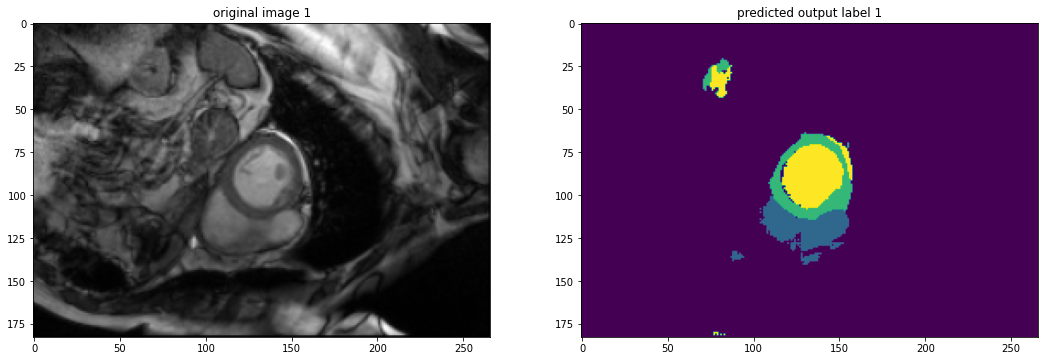

Taking testABC = 3


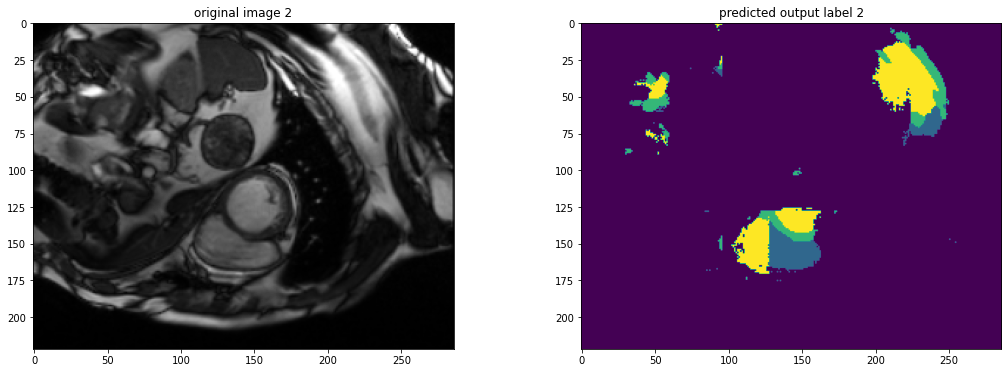

Taking testABC = 14


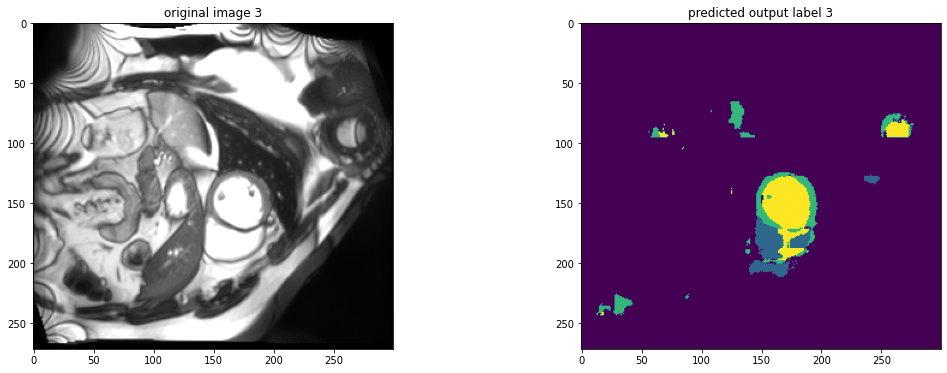

Taking testABC = 10


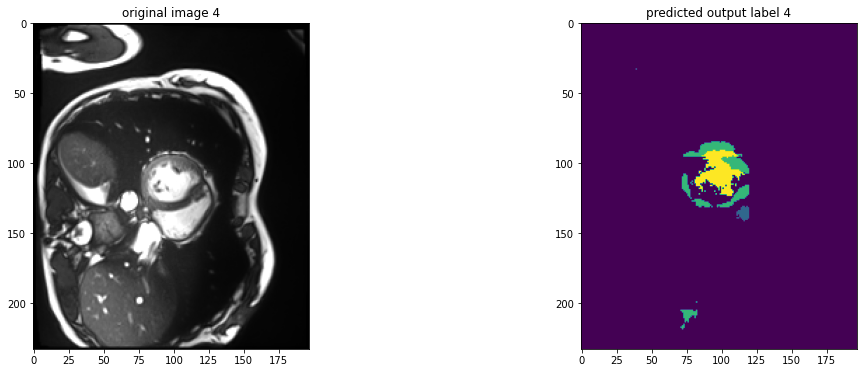

Taking testABC = 13


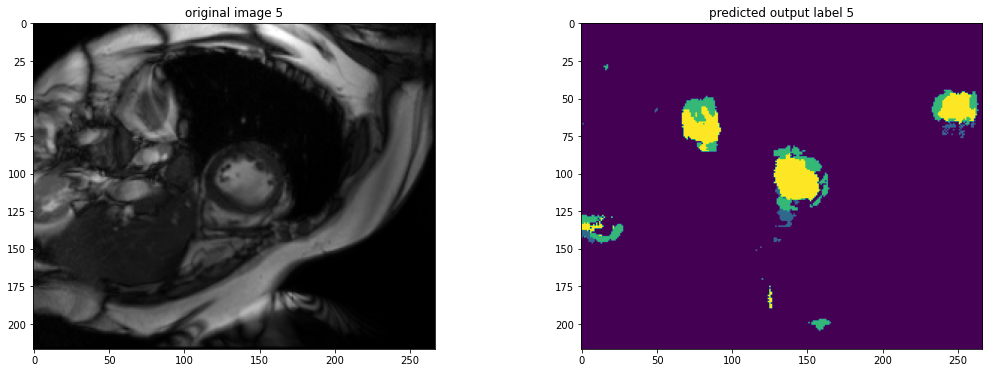

In [ ]:
import random
# testABC = slice_map[img_name]


for case_num in [0,1,2,3,4]:
  testABC = random.randint(2,20)
  print(f"Taking testABC = {testABC}")
  # model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D_BADresult_42min_PadOrCropd_4Samples.pth")))
  # model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D_10074iterations_88min_8RandomCropSamples.pth")))
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACDC_2D.pth")))
  model.eval()
  with torch.no_grad():
      img_name = os.path.split(test_ds[case_num]["image"].meta["filename_or_obj"])[1]
      img = test_ds[case_num]["image"]
      # label = test_ds[case_num]["label"]
      test_inputs = torch.unsqueeze(img, 1).cuda()
      # test_labels = torch.unsqueeze(label, 1).cuda()
      slice_inferer = monai.inferers.SliceInferer(
                                        roi_size=(WidthLength, WidthLength),
                                        sw_batch_size=3,
                                        spatial_dim=2,  # Spatial dim to slice along is defined here -> 0 axial, 1 coronal, 2 sagittal  ## https://docs.monai.io/en/stable/inferers.html
                                        device=torch.device("cuda"),
                                        padding_mode="replicate",
                                        )
      test_outputs = slice_inferer(test_inputs, model).to(device)


      # Figure w/o labels

      plt.figure("check", (18, 6))
      plt.subplot(1, 2, 1)
      plt.title("original image %i" %(case_num+1))
      plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, testABC], cmap="gray")
      plt.subplot(1, 2, 2)
      plt.title("predicted output label %i" %(case_num+1))
      plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, testABC])
      # plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :])
      plt.savefig(os.path.join(root_dir, str(case_num) + "Result_Test_unetr_ACDC_2D.pdf"))
      plt.show()


      ## Figure with labels

      # plt.figure("check", (18, 6))
      # plt.subplot(1, 3, 1)
      # plt.title("original image %i" %(case_num+1))
      # plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, testABC], cmap="gray")
      # plt.subplot(1, 3, 2)
      # plt.title("gt label %i" %(case_num+1))
      # plt.imshow(test_labels.cpu().numpy()[0, 0, :, :, testABC])
      # plt.subplot(1, 3, 3)
      # plt.title("predicted output label %i" %(case_num+1))
      # plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, testABC])
      # # plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :])
      # plt.savefig(os.path.join(root_dir, str(case_num) + "Result_Test_unetr_ACDC_2D.pdf"))
      # plt.show()
